# Analysis of pairwise k-mer Jaccard Similarity - 50 Ecoli genomes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline


In [2]:
import screed

In [3]:
import mmh3

In [4]:
# https://github.com/ipython/ipython/issues/10627
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [5]:

# import ete3 as ETE

# from ete3 import Tree

In [6]:

import ete3 as ETE

from ete3 import Tree

## Define paths to sample metadata files & key directories

In [7]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

SA_PG_MainDir = f"{Proj_MainDir}/241206_Saureus_PG_Analysis"  

Data_MainDir = f"{SA_PG_MainDir}/Data"  

SA_68CI_GenomeFASTAs_Dir = f"{Data_MainDir}/CRS.Saureus.68CI.GenomesFromGitRepo"

HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV = f"{SA_PG_MainDir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"


Saureus_Repo_Meta_Dir = f"../../Data/241206_Saureus_HoutakBouras2023_Metadata"  

Sa_ENA_RunData_TSV = f"{Saureus_Repo_Meta_Dir}/ENA.RunMetadata.PRJNA914892.tsv"

Sa_HoutakBouras2023_Isolate_Metadata_TSV = f"{Saureus_Repo_Meta_Dir}/HoutakBouras2023.metadata.csv"

Sa_HoutakBouras2023_Isolate_MLST_Info_TSV = f"{Saureus_Repo_Meta_Dir}/metadata/poppunk_mlst.csv"



Sa_HoutakBouras2023_NCBI_GenomeInfo_TSV  = f"{Saureus_Repo_Meta_Dir}/NCBI.HoutakBouras2023.Saureus.174CI.HybridGenomes.tsv"

HoutakBouras2023_Saureus_68CI_AsmPATH_TSV = f"{Saureus_Repo_Meta_Dir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"



In [8]:
!ls -1 $Saureus_Repo_Meta_Dir/metadata

biofilm_data.csv
metadata_phylogentic_tree.csv
plassembler_copy_number.csv
poppunk_mlst.csv
rid_time.csv


In [9]:
!ls -1 $Data_MainDir

CRS.Saureus.68CI.GenomesFromGitRepo
ENA.RunMetadata.PRJNA914892.tsv
HoutakBouras2023.metadata.csv
NCBI.HoutakBouras2023.Saureus.174CI.HybridGenomes.tsv


## Parse in SA Isolate MLST Info

In [10]:
MLST_DF = pd.read_csv(Sa_HoutakBouras2023_Isolate_MLST_Info_TSV, sep = ",")
MLST_DF["SampleID"] = MLST_DF["Cnumber_ID"]

MLST_DF["CC"] = MLST_DF["CC"].replace("Not_Assigned", "None")
MLST_DF["ST"] = MLST_DF["ST"].replace("Not_Assigned", "None")

MLST_DF.shape

(68, 7)

In [11]:
MLST_DF

,Cnumber_ID,Gess_plus_Time,Timepoint,PopPUNK_Cluster,ST,CC,SampleID
0,C100,276_T0,T0,6,46,CC45,C100
1,C364,276_T1,T1,2,15,CC15,C364
2,C22,420_T0,T0,27,101,None,C22
3,C320,420_T1,T1,27,101,None,C320
4,C235,539_T0,T0,15,72,CC8,C235
...,...,...,...,...,...,...,...
63,C309,5728_T1,T1,1,None,None,C309
64,C325,5767_T0,T0,2,582,CC15,C325
65,C363,5767_T1,T1,2,5,CC5,C363
66,C311,5911_T0,T0,4,30,CC30,C311


## Parse in metadata DFs

In [12]:
SA_68CI_Info_DF = pd.read_csv(HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV,
                               sep = "\t")
print(SA_68CI_Info_DF.shape)

#Sa_68CI_Info_DF = pd.merge(Sa_68CI_Info_DF, MLST_DF, how = "left",
#                           left_on="SampleID", right_on = "SampleID" )

print(SA_68CI_Info_DF.shape)

(68, 8)
(68, 8)


### Define list of SampleIDs

In [13]:
SA_68CI_Info_DF.head(1)  

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [14]:
SA68I_SampleIDs = SA_68CI_Info_DF["SampleID"].values   
len(SA68I_SampleIDs)

68

### Create lineage mapping for sampleIDs

In [15]:
ID_To_Lineage_Dict = dict(MLST_DF[['SampleID', 'CC']].values)


In [16]:
MLST_DF["CC"].value_counts()

None    24
CC45    14
CC30     9
CC15     5
CC22     5
CC1      5
CC5      4
CC8      2
Name: CC, dtype: int64

In [17]:
MLST_DF["CC"].value_counts().index.sort_values()

Index(['CC1', 'CC15', 'CC22', 'CC30', 'CC45', 'CC5', 'CC8', 'None'], dtype='object')

In [18]:
SA_68CI_Info_DF.head(5)

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
1,C364,276,T1,PRJNA914892,SRR22859839,GCA_030289195.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
2,C22,420,T0,PRJNA914892,SRR22859927,GCA_030290075.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
3,C320,420,T1,PRJNA914892,SRR22859838,GCA_030289995.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
4,C235,539,T0,PRJNA914892,SRR22859837,GCA_030290115.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [19]:
SA_68CI_Info_DF.tail(5)

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
63,C309,5728,T1,PRJNA914892,SRR22860006,GCA_030289135.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
64,C325,5767,T0,PRJNA914892,SRR22860005,GCA_030289055.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
65,C363,5767,T1,PRJNA914892,SRR22860003,GCA_030288995.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
66,C311,5911,T0,PRJNA914892,SRR22860002,GCA_030288935.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...
67,C357,5911,T1,PRJNA914892,SRR22860001,GCA_030289095.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


### Create color mapping for sampleIDs (Based on phylo-lineage)

In [20]:
# Dictionary for lineage to color mapping

LinToColor_Dict = {
    "CC1": "#3BAF9F",  # Teal
    "CC15": "#9DB17C",  # Light Olive Green
    "CC22": "#D2A679",  # Earthy Ochre
    "CC30": "#9E9AC8",  # Soft Lavender
    "CC45": "#F88379",  # Coral Pink
    "CC5": "#BFFF00",  # Bright Lime Green
    "CC8": "#87CEEB",  # Sky Blue
    "None": "black",  # Default for undefined categories
}

# # Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = MLST_DF.set_index('SampleID')['CC'].to_dict()
#lineage_mapping = {}

# # Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}

ID_To_PrimLineage_Dict = lineage_mapping


In [21]:
#ID_To_PrimLineage_Dict

In [22]:
ID_To_PrimLineage_Dict

{'C100': 'CC45',
 'C364': 'CC15',
 'C22': 'None',
 'C320': 'None',
 'C235': 'CC8',
 'C318': 'CC30',
 'C79': 'CC5',
 'C148': 'CC8',
 'C265': 'None',
 'C324': 'None',
 'C13': 'CC30',
 'C76': 'CC30',
 'C80': 'CC45',
 'C208': 'CC45',
 'C240': 'None',
 'C295': 'None',
 'C52': 'CC30',
 'C113': 'CC30',
 'C24': 'CC22',
 'C195': 'CC45',
 'C9': 'CC45',
 'C353': 'CC45',
 'C121': 'CC45',
 'C255': 'CC15',
 'C3': 'None',
 'C56': 'None',
 'C32': 'None',
 'C188': 'CC15',
 'C16': 'CC22',
 'C70': 'CC22',
 'C67': 'CC45',
 'C294': 'CC45',
 'C21': 'None',
 'C273': 'CC30',
 'C72': 'CC45',
 'C351': 'CC45',
 'C133': 'None',
 'C179': 'None',
 'C45': 'None',
 'C149': 'None',
 'C91': 'CC45',
 'C209': 'CC1',
 'C206': 'None',
 'C276': 'None',
 'C136': 'CC45',
 'C197': 'CC5',
 'C155': 'CC15',
 'C339': 'CC1',
 'C196': 'None',
 'C342': 'CC1',
 'C183': 'CC30',
 'C312': 'None',
 'C182': 'None',
 'C233': 'None',
 'C224': 'CC1',
 'C349': 'CC1',
 'C222': 'CC22',
 'C333': 'CC22',
 'C245': 'None',
 'C314': 'CC45',
 'C285': 

### Look at lineage distribution across dataset

In [23]:
MLST_DF["CC"].value_counts()

None    24
CC45    14
CC30     9
CC15     5
CC22     5
CC1      5
CC5      4
CC8      2
Name: CC, dtype: int64

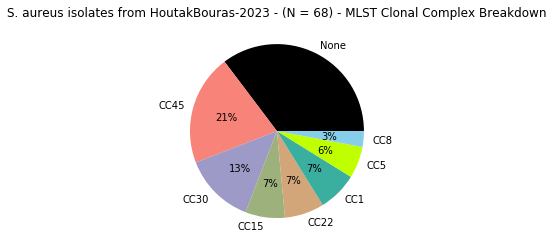

In [24]:
# https://www.statology.org/seaborn-pie-chart/

#define data
data = MLST_DF["CC"].value_counts().values
labels = MLST_DF["CC"].value_counts().index


colors_for_labels = [ LinToColor_Dict[label] for label in labels]

plt.title("S. aureus isolates from HoutakBouras-2023 - (N = 68) - MLST Clonal Complex Breakdown")
plt.pie(data, labels = labels, colors = colors_for_labels, autopct='%.0f%%')
plt.show()


In [25]:
data

array([24, 14,  9,  5,  5,  5,  4,  2])

In [26]:
labels

Index(['None', 'CC45', 'CC30', 'CC15', 'CC22', 'CC1', 'CC5', 'CC8'], dtype='object')

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [27]:
!ls -1 $Ecoli_PG_MainDir/

bin
boot
dev
etc
home
lib
lib64
media
mnt
n
opt
proc
programs
root
run
sbin
srv
sys
tmp
usr
var
www


In [28]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{SA_PG_MainDir}/SMK_OutDirs"

PG_SA_68I_OutDir = WGA_SMK_Outputs_Dir + "/241206_Saureus_HoutakBouras2023_68I_V1"


In [29]:
!ls -1 $WGA_SMK_Outputs_Dir

241206_Saureus_HoutakBouras2023_68I_V1


In [30]:
target_OutputDir = PG_SA_68I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


In [31]:
ID_To_PrimLineage_Dict

{'C100': 'CC45',
 'C364': 'CC15',
 'C22': 'None',
 'C320': 'None',
 'C235': 'CC8',
 'C318': 'CC30',
 'C79': 'CC5',
 'C148': 'CC8',
 'C265': 'None',
 'C324': 'None',
 'C13': 'CC30',
 'C76': 'CC30',
 'C80': 'CC45',
 'C208': 'CC45',
 'C240': 'None',
 'C295': 'None',
 'C52': 'CC30',
 'C113': 'CC30',
 'C24': 'CC22',
 'C195': 'CC45',
 'C9': 'CC45',
 'C353': 'CC45',
 'C121': 'CC45',
 'C255': 'CC15',
 'C3': 'None',
 'C56': 'None',
 'C32': 'None',
 'C188': 'CC15',
 'C16': 'CC22',
 'C70': 'CC22',
 'C67': 'CC45',
 'C294': 'CC45',
 'C21': 'None',
 'C273': 'CC30',
 'C72': 'CC45',
 'C351': 'CC45',
 'C133': 'None',
 'C179': 'None',
 'C45': 'None',
 'C149': 'None',
 'C91': 'CC45',
 'C209': 'CC1',
 'C206': 'None',
 'C276': 'None',
 'C136': 'CC45',
 'C197': 'CC5',
 'C155': 'CC15',
 'C339': 'CC1',
 'C196': 'None',
 'C342': 'CC1',
 'C183': 'CC30',
 'C312': 'None',
 'C182': 'None',
 'C233': 'None',
 'C224': 'CC1',
 'C349': 'CC1',
 'C222': 'CC22',
 'C333': 'CC22',
 'C245': 'None',
 'C314': 'CC45',
 'C285': 

## Parse IQ-Tree phylogeny

In [32]:
Phylos_OutDir = f"{target_OutputDir}/Phylogenies"

IQTree_OutDir = f"{Phylos_OutDir}/iqtree"

IQ_Tree_MP_PATH = f"{IQTree_OutDir}/Panaroo.Strict.MergeParalogs.MidRoot.WiNodeNames.newick"    


In [33]:
IQ_Tree_MP = Tree(IQ_Tree_MP_PATH, format = 1)


In [34]:
# Count the number of nodes after midpoint rooting
num_nodes = len(IQ_Tree_MP.get_leaves()) + len([node for node in IQ_Tree_MP.traverse() if not node.is_leaf()])

print(num_nodes)

135


In [35]:
ID_To_PrimLineage_Dict

{'C100': 'CC45',
 'C364': 'CC15',
 'C22': 'None',
 'C320': 'None',
 'C235': 'CC8',
 'C318': 'CC30',
 'C79': 'CC5',
 'C148': 'CC8',
 'C265': 'None',
 'C324': 'None',
 'C13': 'CC30',
 'C76': 'CC30',
 'C80': 'CC45',
 'C208': 'CC45',
 'C240': 'None',
 'C295': 'None',
 'C52': 'CC30',
 'C113': 'CC30',
 'C24': 'CC22',
 'C195': 'CC45',
 'C9': 'CC45',
 'C353': 'CC45',
 'C121': 'CC45',
 'C255': 'CC15',
 'C3': 'None',
 'C56': 'None',
 'C32': 'None',
 'C188': 'CC15',
 'C16': 'CC22',
 'C70': 'CC22',
 'C67': 'CC45',
 'C294': 'CC45',
 'C21': 'None',
 'C273': 'CC30',
 'C72': 'CC45',
 'C351': 'CC45',
 'C133': 'None',
 'C179': 'None',
 'C45': 'None',
 'C149': 'None',
 'C91': 'CC45',
 'C209': 'CC1',
 'C206': 'None',
 'C276': 'None',
 'C136': 'CC45',
 'C197': 'CC5',
 'C155': 'CC15',
 'C339': 'CC1',
 'C196': 'None',
 'C342': 'CC1',
 'C183': 'CC30',
 'C312': 'None',
 'C182': 'None',
 'C233': 'None',
 'C224': 'CC1',
 'C349': 'CC1',
 'C222': 'CC22',
 'C333': 'CC22',
 'C245': 'None',
 'C314': 'CC45',
 'C285': 

### Add lineage info to tree and sort by sub-lineage

In [36]:
count = 0
for n in IQ_Tree_MP.get_leaves():

    if "Bakta" in n.name:
        n.name = n.name.split(".")[0]
    
    n.add_feature("Primary_lineage", ID_To_PrimLineage_Dict.get(n.name, "Unknown Lineage") )

    count +=1

print(count)  
IQ_Tree_MP.sort_descendants(attr='Primary_lineage')


68


## Parsing over each node of the tree (ETE3) and infer lineage

In [37]:
IQ_node_To_PrimaryLin_Dict = {}

for node in IQ_Tree_MP.iter_descendants("postorder"):
    # Do some analysis on node
    
    #print(node.name)
    listOf_ChildLineages = []
    
    for child_node in node.get_descendants():
        if child_node.is_leaf():
            listOf_ChildLineages.append(  (child_node.Primary_lineage) )
        
        #print(node.name, listOf_ChildLineages)
        
    set_Of_ChildLineages = list(set(listOf_ChildLineages))

    #print(node.name, set_Of_ChildLineages  )
    
    if len(set_Of_ChildLineages) == 1:
        OnlyOneLineage = True
    else:
        OnlyOneLineage = False
    
    if OnlyOneLineage:
        IQ_node_To_PrimaryLin_Dict[node.name] = set_Of_ChildLineages[0]

IQ_node_To_PrimaryLin_Dict.update(ID_To_PrimLineage_Dict)
    

## Output "node_To_PrimaryLin_Dict" dictionary 

In [38]:
import json 

!mkdir PhyloInfo/
IQ_NodeToPriLineage_Dict_JSON = f"{IQTree_OutDir}/IQTrees.NodeToPrimaryLineage.json"

with open(IQ_NodeToPriLineage_Dict_JSON, 'w') as json_file:
   json.dump(IQ_node_To_PrimaryLin_Dict, json_file)


mkdir: cannot create directory ‘PhyloInfo/’: File exists


#### test reading back in the JSON

In [39]:
with open(IQ_NodeToPriLineage_Dict_JSON) as json_file:
   IQ_node_To_PrimaryLin_Dict = json.load(json_file)

In [40]:
len(list(IQ_node_To_PrimaryLin_Dict.keys()))

102

In [41]:
IQ_node_To_PrimaryLin_Dict

{'Node_61': 'CC1',
 'Node_54': 'CC1',
 'Node_53': 'None',
 'Node_64': 'None',
 'Node_62': 'None',
 'Node_48': 'CC1',
 'Node_56': 'CC5',
 'Node_49': 'CC5',
 'Node_65': 'CC15',
 'Node_66': 'CC15',
 'Node_63': 'CC15',
 'Node_59': 'CC15',
 'Node_58': 'None',
 'Node_57': 'None',
 'Node_50': 'None',
 'Node_17': 'None',
 'Node_18': 'None',
 'Node_10': 'None',
 'Node_5': 'None',
 'Node_27': 'CC22',
 'Node_16': 'CC22',
 'Node_9': 'CC22',
 'Node_4': 'CC22',
 'Node_60': 'None',
 'Node_42': 'CC30',
 'Node_21': 'CC30',
 'Node_12': 'CC30',
 'Node_44': 'CC45',
 'Node_33': 'CC45',
 'Node_34': 'CC45',
 'Node_24': 'CC45',
 'Node_45': 'CC45',
 'Node_36': 'CC45',
 'Node_25': 'CC45',
 'C100': 'CC45',
 'C364': 'CC15',
 'C22': 'None',
 'C320': 'None',
 'C235': 'CC8',
 'C318': 'CC30',
 'C79': 'CC5',
 'C148': 'CC8',
 'C265': 'None',
 'C324': 'None',
 'C13': 'CC30',
 'C76': 'CC30',
 'C80': 'CC45',
 'C208': 'CC45',
 'C240': 'None',
 'C295': 'None',
 'C52': 'CC30',
 'C113': 'CC30',
 'C24': 'CC22',
 'C195': 'CC45'

### Link to ETE3 documentation for tree layout style
 http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#interactive-visualization-of-trees

In [42]:

node_To_PrimaryLin_Dict= IQ_node_To_PrimaryLin_Dict
def ColorBranchByLineage_Layout(node):
    F = ETE.TextFace(node.name, fsize=2)
    if node.is_leaf():
        #NameAnd_Lineage_Text =  f"  {node.name} {node.Mtb_lineage}"
        #F_NameAndLineage = ETE.TextFace(NameAnd_Lineage_Text, fsize=3)
        
        #ETE.add_face_to_node(F_NameAndLineage, node, column=0, position="branch-right")

        
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 1
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
          
        node.set_style(nstyle)
        node.margin_left = 10        
    else: 
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 0
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        node.set_style(nstyle)


ts_1 = ETE.TreeStyle()
ts_1.show_leaf_name = False
ts_1.show_branch_length = False
ts_1.show_branch_support = False
ts_1.show_scale = False #True
#ts_1.branch_vertical_margin = 2
ts_1.layout_fn = ColorBranchByLineage_Layout
ts_1.rotation = 90


ts_3 = ETE.TreeStyle()
ts_3.show_leaf_name = False
ts_3.show_branch_length = False
ts_3.show_branch_support = False
ts_3.show_scale = True #True
ts_3.branch_vertical_margin = 2
ts_3.layout_fn = ColorBranchByLineage_Layout
ts_3.rotation = 90
ts_3.scale_length = 0.001

ts_3_circ = ETE.TreeStyle()
ts_3_circ.mode = "c" # draw tree in circular mode
ts_3_circ.arc_start = 0 #-180 # 0 degrees = 3 o'clock
ts_3_circ.arc_span = 270
ts_3_circ.show_leaf_name = False
ts_3_circ.show_branch_length = False
ts_3_circ.show_branch_support = False
ts_3_circ.show_scale = False #True
ts_3_circ.branch_vertical_margin = 2
ts_3_circ.layout_fn = ColorBranchByLineage_Layout


## Visualize IQ-Tree Phylogeny

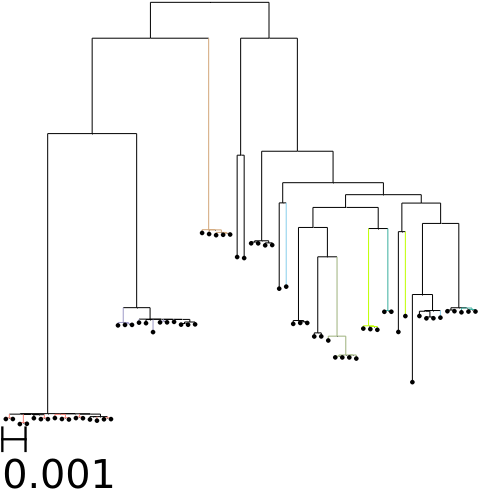

In [43]:
IQ_Tree_MP.render("%%inline", h = 500, tree_style = ts_3)

In [44]:
!mkdir Results5_Plots/

mkdir: cannot create directory ‘Results5_Plots/’: File exists


In [45]:
Z = IQ_Tree_MP.render("Results5_Plots/6.SA68CI.RectPhylo.png", w = 1000, tree_style = ts_3)     

In [46]:
Z = IQ_Tree_MP.render("Results5_Plots/6.SA68CI.RectPhylo.svg", w = 1000, tree_style = ts_3)    

In [47]:
OrderOfSampleIDs_Phylo = [ n.name for n in IQ_Tree_MP.get_leaves() ]  

In [48]:
print(OrderOfSampleIDs_Phylo)

['C342', 'C339', 'C209', 'C133', 'C179', 'C148', 'C241', 'C309', 'C355', 'C295', 'C197', 'C240', 'C224', 'C349', 'C285', 'C79', 'C363', 'C155', 'C255', 'C188', 'C364', 'C325', 'C182', 'C196', 'C149', 'C45', 'C233', 'C235', 'C245', 'C320', 'C22', 'C56', 'C3', 'C32', 'C312', 'C333', 'C222', 'C24', 'C70', 'C16', 'C273', 'C324', 'C265', 'C183', 'C113', 'C52', 'C357', 'C276', 'C311', 'C13', 'C76', 'C318', 'C9', 'C353', 'C195', 'C206', 'C208', 'C80', 'C67', 'C294', 'C314', 'C91', 'C136', 'C21', 'C72', 'C351', 'C100', 'C121']


In [49]:
#!ls -1 $IQTree_OutDir

### Copy E. coli phylogeny related files

In [50]:
# Ecoli_50CI_Phylogroups_TSV = f"{IQTree_OutDir}/Ecoli.50CI.Phylogroups.tsv"

# IQ_NodeToPriLineage_Dict_JSON = f"{IQTree_OutDir}/IQTrees.NodeToPrimaryLineage.json"

# IQ_Tree_MP_PATH = f"{IQTree_OutDir}/Panaroo.Strict.MergeParalogs.MidRoot.WiNodeNames.newick"    

# # Copy Phylogeny related files to a data
# !mkdir ../../Data/Ecoli_50CI_Phylo/

# !cp $Ecoli_50CI_Phylogroups_TSV ../../Data/Ecoli_50CI_Phylo/
# !cp $IQ_NodeToPriLineage_Dict_JSON ../../Data/Ecoli_50CI_Phylo/

# !cp $IQ_Tree_MP_PATH ../../Data/Ecoli_50CI_Phylo/Ecoli50CI.Phylo.iqtree.newick


In [51]:
#!ls -1 ../../Data/Ecoli_50CI_Phylo/

In [52]:
#!ls -alh $PG_Ecoli_50I_OutDir

## Define paths to all Assembly FAs + BAKTA Annotations (Short + Long read ASMs)

In [53]:
listOfSample_Tags = SA68I_SampleIDs

target_SMK_OutputDir = target_OutputDir

SampleTag_ToPaths_Dict = {}

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = target_SMK_OutputDir + "/AsmAnalysis/" + SampleID
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    # LR Bakta Anno Files
    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    
    i_LRAsm_Bakta_GFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3"
    i_LRAsm_Bakta_GBFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff"
    i_LRAsm_Bakta_FAA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa"
    i_LRAsm_Bakta_FFN = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn"
    i_LRAsm_Bakta_FNA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna"
    i_LRAsm_Bakta_TXT = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt"

    dictOfPaths_Temp = {}
    dictOfPaths_Temp["LRAsm_Bakta_GFF"] = i_LRAsm_Bakta_GFF  
    dictOfPaths_Temp["LRAsm_Bakta_GBFF"] = i_LRAsm_Bakta_GBFF
    dictOfPaths_Temp["LRAsm_Bakta_FAA"] = i_LRAsm_Bakta_FAA    
    dictOfPaths_Temp["LRAsm_Bakta_FFN"] = i_LRAsm_Bakta_FFN    
    dictOfPaths_Temp["LRAsm_Bakta_FNA"] = i_LRAsm_Bakta_FNA  
    dictOfPaths_Temp["LRAsm_Bakta_TXT"] = i_LRAsm_Bakta_TXT 
    
    SampleTag_ToPaths_Dict[SampleID] = dictOfPaths_Temp


In [54]:
listOfSample_Tags[0]

'C100'

In [55]:
#!ls -1 $Bakta_AsmDir

In [56]:
SampleTag_ToPaths_Dict['C100']["LRAsm_Bakta_FNA"] 

'/n/data1/hms/dbmi/farhat/mm774/Projects/241206_Saureus_PG_Analysis/SMK_OutDirs/241206_Saureus_HoutakBouras2023_68I_V1/AsmAnalysis/C100/GenomeAnnotation/C100_Asm_Bakta/C100.Bakta.fna'

In [57]:
!ls -alh $target_SMK_OutputDir/FastANI

total 0
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:22 .
drwxrwsr-x 2 mm774 farhat 4.0K Dec  9 17:09 ..
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:31 FastANI_LRAsm
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:18 FastANI_LRAsms


In [58]:
!ls -alh $target_SMK_OutputDir/FastANI/FastANI_LRAsm

total 1.7M
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:31 .
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:22 ..
-rw-rw-r-- 1 mm774 farhat 1.7M Dec  6 17:32 FastANI.AllVsAll.LRAsm.txt


In [59]:
!ls -alh $target_SMK_OutputDir/FastANI/FastANI_LRAsms

total 13K
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:18 .
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:22 ..
-rw-rw-r-- 1 mm774 farhat  13K Dec  6 17:18 LRAsms.PathToFASTAs.txt


## Parse SourMASH output files

In [60]:
SourMASH_MainDir = f"{target_SMK_OutputDir}/SourMash"

# SourMASH Default Out
SourMASH_AllVsAll_Default_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Default"

SM_AvA_Default_JS_OUT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out"
SM_AvA_Default_Labels_TXT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out.labels.txt"

# SourMASH Scaled Out
SourMASH_AllVsAll_Scaled_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Scaled1"

SM_AvA_Scaled1_JS_OUT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out"
SM_AvA_Scaled1_Labels_TXT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out.labels.txt"


In [61]:
!ls -l $SourMASH_MainDir/CompareAllAsm_Scaled1

total 97
-rw-rw-r-- 1 mm774 farhat 37120 Dec  6 17:02 SourMash.Compare.Scaled1.out
-rw-rw-r-- 1 mm774 farhat 17853 Dec  6 17:02 SourMash.Compare.Scaled1.out.dendro.pdf
-rw-rw-r-- 1 mm774 farhat  8900 Dec  6 17:01 SourMash.Compare.Scaled1.out.hist.pdf
-rw-rw-r-- 1 mm774 farhat  8071 Dec  6 17:01 SourMash.Compare.Scaled1.out.labels.txt
-rw-rw-r-- 1 mm774 farhat 25670 Dec  6 17:02 SourMash.Compare.Scaled1.out.matrix.pdf


In [62]:
SM_AvA_Labels = pd.read_csv(SM_AvA_Scaled1_Labels_TXT, sep = "\t", header = None)[0].str.split("/").str[-1].str.split(".").str[0]
SM_AvA_Labels.shape

(68,)

In [63]:
SM_AvA_Labels.head(3)

0    C100
1    C364
2     C22
Name: 0, dtype: object

## Parse the Jaccard Simularity of k-mers (k = 31 bp)

In [64]:
AvA_LR_JS_NP = np.load(SM_AvA_Scaled1_JS_OUT)
AvA_LR_JS_DF = pd.DataFrame(AvA_LR_JS_NP)

AvA_LR_JS_DF.columns = SM_AvA_Labels
AvA_LR_JS_DF.index = SM_AvA_Labels


In [65]:
AvA_LR_JS_DF.head(2)

,C100,C364,C22,C320,C235,C318,C79,C148,C265,C324,...,C245,C314,C285,C355,C241,C309,C325,C363,C311,C357
0,,,,,,,,,,,,,,,,,,,,,
C100,1.000000,0.398233,0.404979,0.404923,0.411829,0.434010,0.403214,0.392454,0.446544,0.446544,...,0.414614,0.929841,0.401540,0.405164,0.399394,0.399292,0.389317,0.409561,0.446352,0.451308
C364,0.398233,1.000000,0.645445,0.645429,0.678118,0.417422,0.645267,0.671411,0.430026,0.430019,...,0.665614,0.399259,0.645449,0.675799,0.675460,0.675252,0.899614,0.646797,0.425386,0.426445


In [66]:
AvA_LR_JS_DF.index = AvA_LR_JS_DF.index.rename("SampleID_1")
AvA_LR_JS_DF.columns = AvA_LR_JS_DF.columns.rename("SampleID_2")

LR_JaccSim_Pairwise_DF = AvA_LR_JS_DF.stack().reset_index()

LR_JaccSim_Pairwise_DF.columns = ["SampleID_1", "SampleID_2", "Mash_JS"]
LR_JaccSim_Pairwise_DF.sort_values(["SampleID_1", "SampleID_2"])

LR_JaccSim_Pairwise_DF = LR_JaccSim_Pairwise_DF.query(" SampleID_1 != SampleID_2 ")

LR_JaccSim_Pairwise_DF.shape 

(4556, 3)

In [67]:
LR_JaccSim_Pairwise_DF.head(2)

,SampleID_1,SampleID_2,Mash_JS
1,C100,C364,0.398233
2,C100,C22,0.404979


In [68]:
LR_JaccSim_Pairwise_DF.sort_values("Mash_JS", ascending=True).head(4)

,SampleID_1,SampleID_2,Mash_JS
4027,C314,C295,0.384821
1079,C295,C314,0.384821
2735,C91,C295,0.385301
1060,C295,C91,0.385301


In [69]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    4556.000000
mean        0.531142
std         0.168404
min         0.384821
25%         0.412837
50%         0.443265
75%         0.645407
max         0.999942
Name: Mash_JS, dtype: float64

#### output parsed 31-mer Jaccard Similarity results to TSV

In [70]:
GenomeSim_OutDir = "../../Data/GenomeSimilarity_MtbAndEcoli"
!mkdir $GenomeSim_OutDir

mkdir: cannot create directory ‘../../Data/GenomeSimilarity_MtbAndEcoli’: File exists


In [71]:
KmerJS_AvA_Mtb_TSV = f"{GenomeSim_OutDir}/Sourmash.31merJaccardSim.Stats.Saureus68CI.tsv"

LR_JaccSim_Pairwise_DF.to_csv(KmerJS_AvA_Mtb_TSV, sep = "\t", index=False)

In [72]:
!ls -1 $GenomeSim_OutDir

FastANI.Stats.Ecoli50CI.tsv
FastANI.Stats.Mtb151CI.tsv
FastANI.Stats.Saureus68CI.tsv
Sourmash.31merJaccardSim.Stats.Ecoli50CI.tsv
Sourmash.31merJaccardSim.Stats.Mtb151CI.tsv
Sourmash.31merJaccardSim.Stats.Saureus68CI.tsv


# Plot the distribution of K-mer JCs between all LR Assemblies

In [73]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    4556.000000
mean        0.531142
std         0.168404
min         0.384821
25%         0.412837
50%         0.443265
75%         0.645407
max         0.999942
Name: Mash_JS, dtype: float64

In [74]:
sns.set_context("paper", font_scale=3)

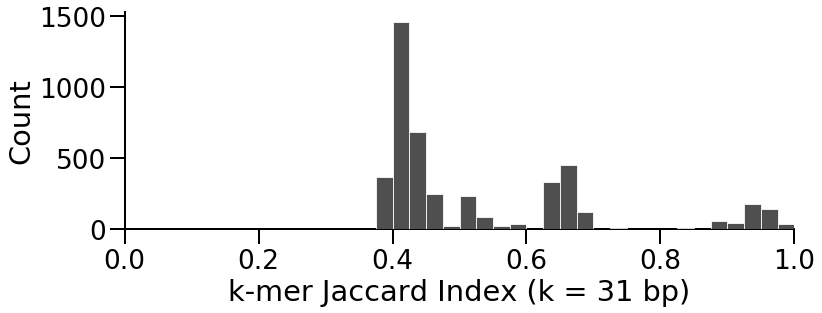

In [75]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(LR_JaccSim_Pairwise_DF["Mash_JS"], bins = np.arange(0, 1.05, 0.025), edgecolor='white', color = '#4F4F4F', alpha = 1, ax = ax1, zorder = 3)
             # hist_kws={"rwidth":0.75,'edgecolor':'none', 'alpha':1.0})
sns.despine()

#ax1.set_axisbelow(True)


#plt.title("Distr. of pair-wise predicted ANI \n (158 Mtb isolates) ")

plt.xlabel("k-mer Jaccard Index (k = 31 bp)")
#plt.ylabel("# of genome pairs")
plt.ylabel("Count")
plt.xlim(0, 1.00)

ticks_ax_limewidth = 2

ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

#plt.tight_layout()



plt.savefig("Results5_Plots/6.Saureus68CI.KmerJS.Histo.png", dpi = 300)
plt.savefig("Results5_Plots/6.Saureus68CI.KmerJS.Histo.svg")
plt.show()


In [76]:
LR_JaccSim_Pairwise_DF.query("Mash_JS == 1")

,SampleID_1,SampleID_2,Mash_JS


## Make a HeatMap of Jaccard Simularity between assemblies

In [77]:
#OrderOfSampleIDs_Phylo

In [78]:
# Reorder the matrix of Jaccard Sim between all assemblies to fit phylogeny

AvA_LR_JS_Ordered_DF = AvA_LR_JS_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
AvA_LR_JS_Ordered_DF.shape

(68, 68)

#### Make sample lineage & color mapping

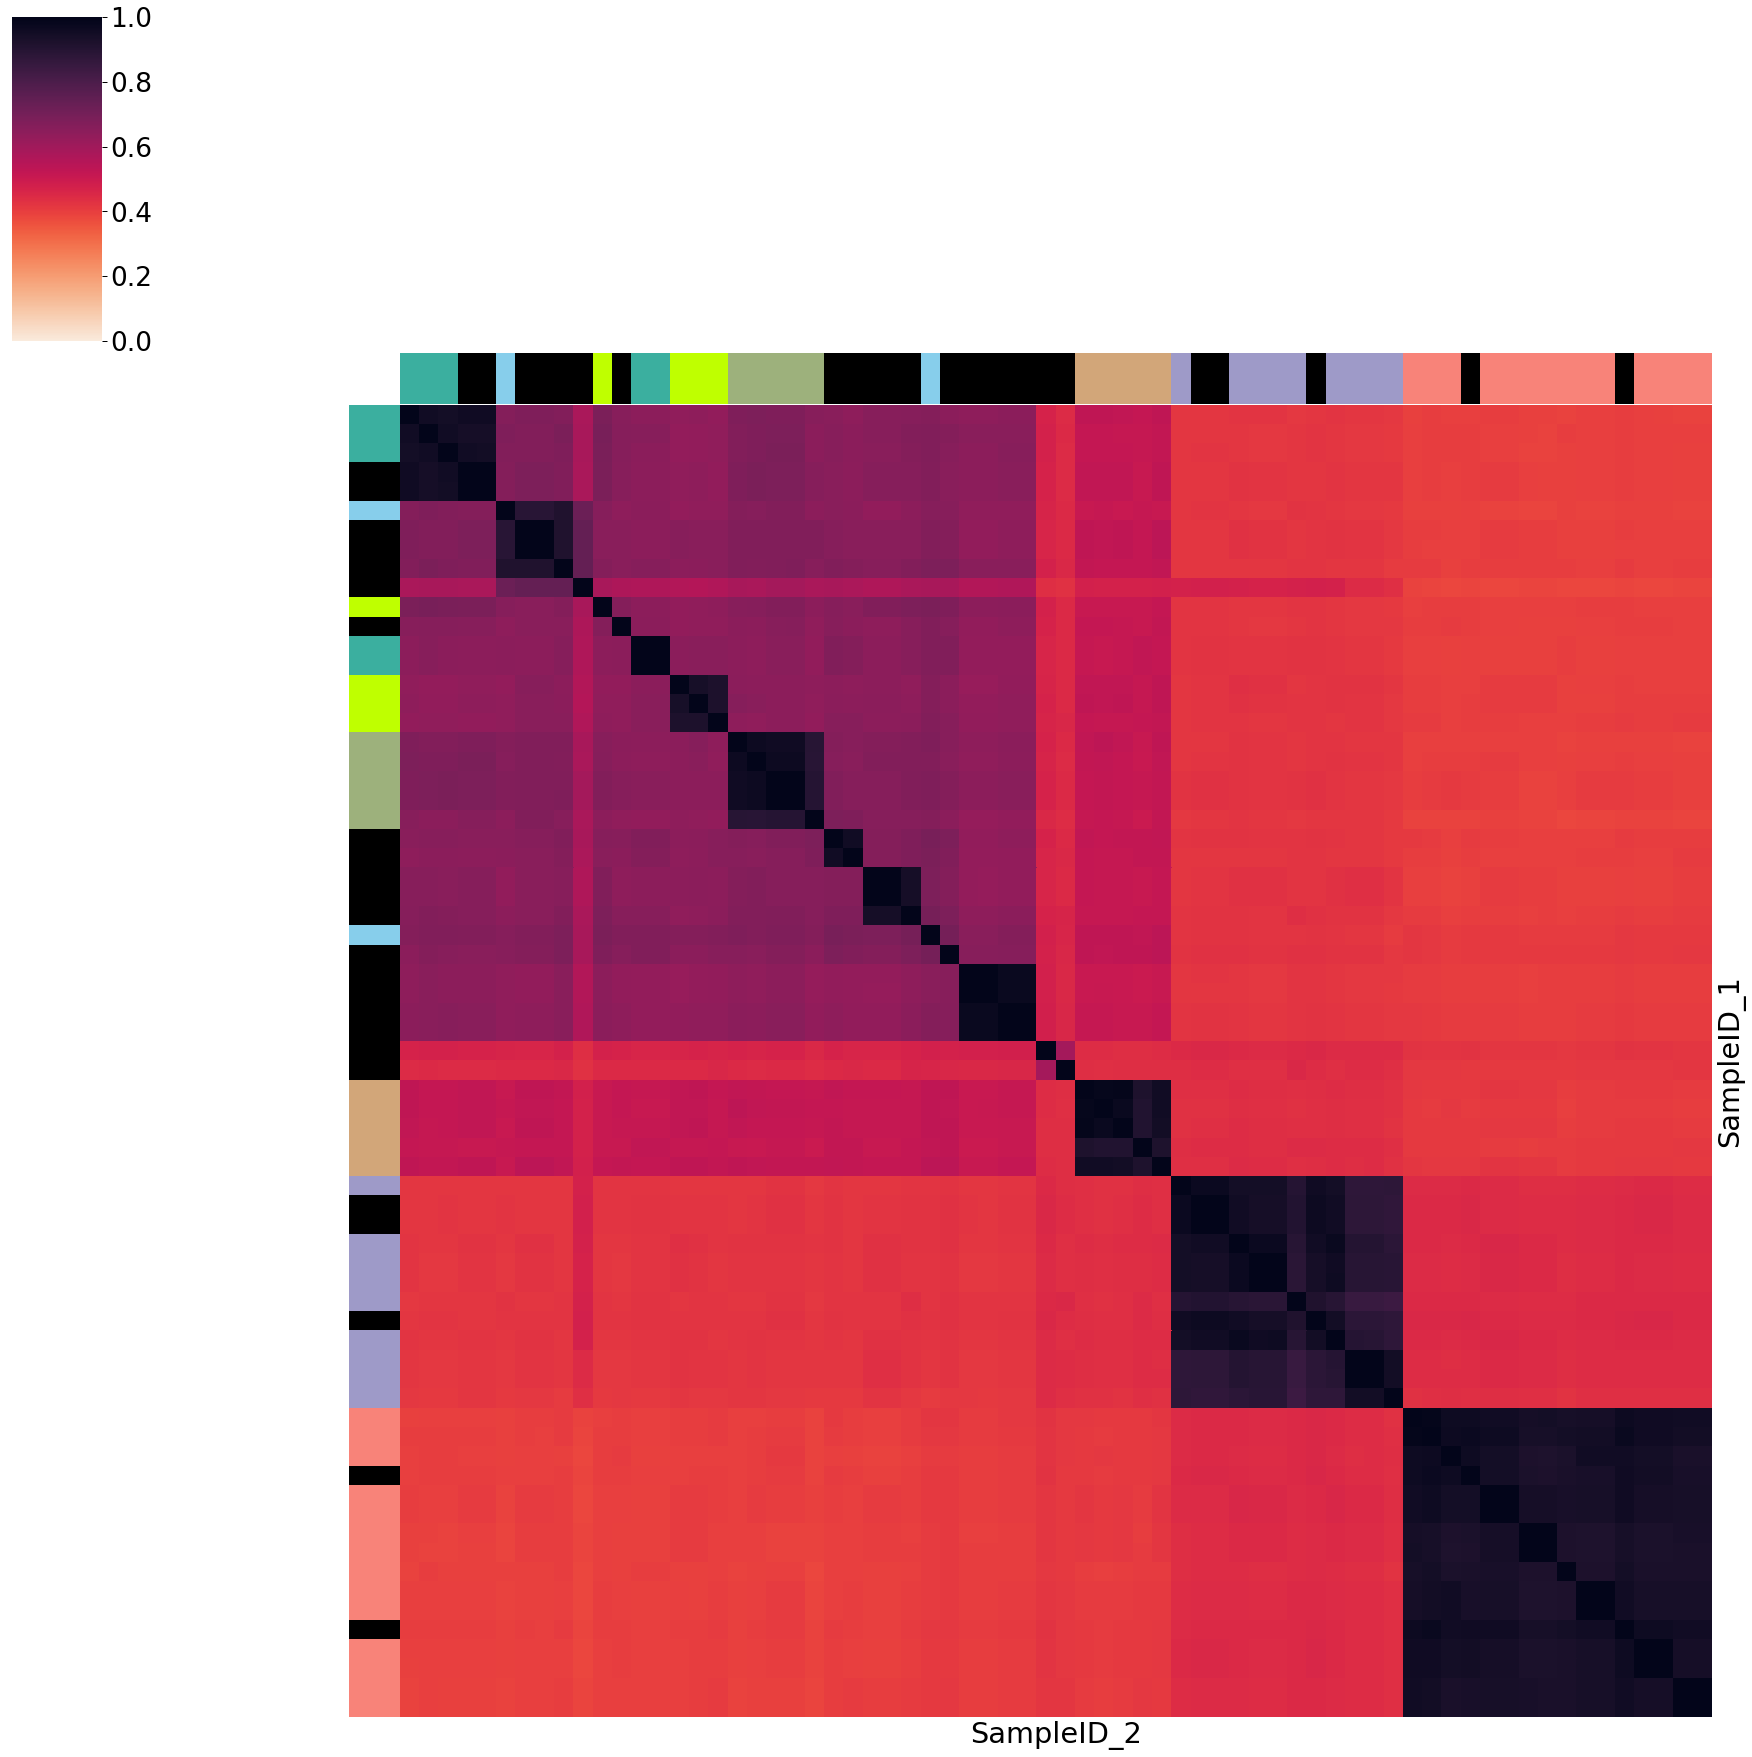

In [79]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 0 )

plt.ylabel("")
plt.xlabel("")

plt.savefig("Results5_Plots/6.Saureus68CI.KmerJS.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results5_Plots/6.Saureus68CI.KmerJS.heatmap.NoLabels.svg")
plt.show()

# Parse FastANI output (All vs All)

In [80]:
FastANI_MainDir = f"{target_SMK_OutputDir}/FastANI"

LR_Asm_AllVsAll_OutDir = f"{FastANI_MainDir}/FastANI_LRAsm"

AvA_158CI_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.LRAsm.txt"

#AvA_158CIWiH37Rv_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.WiH37Rv.LRAsm.txt"     



In [81]:
!ls -lah $LR_Asm_AllVsAll_OutDir

total 1.7M
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:31 .
drwxrwsr-x 2 mm774 farhat 4.0K Dec  6 17:22 ..
-rw-rw-r-- 1 mm774 farhat 1.7M Dec  6 17:32 FastANI.AllVsAll.LRAsm.txt


In [82]:
FANI_AvA_DF = pd.read_csv(AvA_158CI_FastANI_LRAsm_TXT, sep = "\t", header = None)
FANI_AvA_DF.columns = ["Query", "Ref", "ANI", "Bidirect_FragMap", "Total_Query_Frags"]

# Trim down full file path to JUST the SampleID (For Query and Reference genomes)
FANI_AvA_DF["Query"] = FANI_AvA_DF["Query"].str.split("/").str[-1].str.split(".").str[0]
FANI_AvA_DF["Ref"] = FANI_AvA_DF["Ref"].str.split("/").str[-1].str.split(".").str[0]

FANI_AvA_DF.shape

(4624, 5)

In [83]:
FANI_AvA_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,C100,C100,100.0000,925,928
1,C100,C121,99.9995,922,928


In [84]:
FANI_AvA_NoSelf_DF = FANI_AvA_DF.query(" Query != Ref ")
FANI_AvA_NoSelf_DF.shape

(4556, 5)

In [85]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    4556.000000
mean       98.167086
std         0.797338
min        97.234800
25%        97.537300
50%        97.807000
75%        98.885925
max        99.999800
Name: ANI, dtype: float64

In [86]:
FANI_AvA_NoSelf_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
1,C100,C121,99.9995,922,928
2,C100,C9,99.9338,894,928


In [87]:
#FANI_AvA_Ordered_DF = FANI_AvA_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
#FANI_AvA_Ordered_DF.shape

In [88]:
FANI_AvA_NoSelf_DF.sort_values("ANI", ascending=True).head(15)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
3059,C136,C148,97.2348,870,918
2787,C91,C148,97.2423,871,918
1563,C121,C148,97.2707,871,923
543,C148,C91,97.2722,869,952
67,C100,C325,97.2836,857,928
1562,C121,C325,97.2879,863,923
4079,C314,C325,97.2921,867,940
542,C148,C136,97.2973,868,952
541,C148,C100,97.2993,876,952
1359,C195,C148,97.3012,855,899


In [89]:
ID_To_Lineage_Dict["C136"]

'CC45'

In [90]:
ID_To_Lineage_Dict["C148"]

'CC8'

In [91]:
ID_To_Lineage_Dict["C91"]

'CC45'

#### output parsed FastANI results to TSV

In [92]:
GenomeSim_OutDir = "../../Data/GenomeSimilarity_MtbAndEcoli"
!mkdir $GenomeSim_OutDir

mkdir: cannot create directory ‘../../Data/GenomeSimilarity_MtbAndEcoli’: File exists


In [93]:
FANI_AvA_Mtb_TSV = f"{GenomeSim_OutDir}/FastANI.Stats.Saureus68CI.tsv"

FANI_AvA_DF.to_csv(FANI_AvA_Mtb_TSV, sep = "\t", index=False)

In [94]:
!ls -1 $GenomeSim_OutDir

FastANI.Stats.Ecoli50CI.tsv
FastANI.Stats.Mtb151CI.tsv
FastANI.Stats.Saureus68CI.tsv
Sourmash.31merJaccardSim.Stats.Ecoli50CI.tsv
Sourmash.31merJaccardSim.Stats.Mtb151CI.tsv
Sourmash.31merJaccardSim.Stats.Saureus68CI.tsv


# Plot the distribution of pairwise predicted ANIs 

In [95]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    4556.000000
mean       98.167086
std         0.797338
min        97.234800
25%        97.537300
50%        97.807000
75%        98.885925
max        99.999800
Name: ANI, dtype: float64

In [96]:
sns.set_context("paper", font_scale=3)


In [97]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    4556.000000
mean       98.167086
std         0.797338
min        97.234800
25%        97.537300
50%        97.807000
75%        98.885925
max        99.999800
Name: ANI, dtype: float64

In [98]:
sns.set_context("paper", font_scale=3)


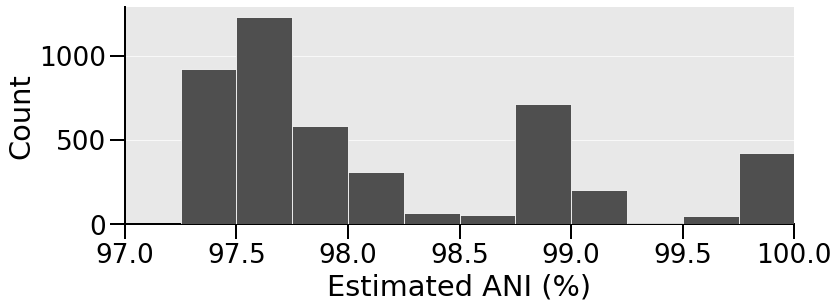

In [99]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(FANI_AvA_NoSelf_DF["ANI"],  bins = np.arange(90, 101, 0.25),
             edgecolor='white', color = '#4F4F4F',
             alpha = 1, ax = ax1, zorder = 3)

sns.despine()

plt.xlabel("Estimated ANI (%)")
plt.ylabel("Count")
plt.xlim(97, 100)

ticks_ax_limewidth = 2
ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

plt.savefig("Results5_Plots/6.Saureus68CI.ANI.Histo.png", dpi = 300)
plt.savefig("Results5_Plots/6.Saureus68CI.ANI.Histo.svg")

plt.show()


In [100]:
FANI_AvA_DF.head()

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,C100,C100,100.0000,925,928
1,C100,C121,99.9995,922,928
2,C100,C9,99.9338,894,928
3,C100,C21,99.9138,903,928
4,C100,C195,99.8888,890,928


In [101]:
FANI_AvA_DF["ANI"].describe()

count    4624.000000
mean       98.194041
std         0.821636
min        97.234800
25%        97.539675
50%        97.820750
75%        98.899150
max       100.000000
Name: ANI, dtype: float64

In [102]:
FANI_AvA_Pivot = FANI_AvA_DF.pivot(index='Query', columns='Ref', values='ANI')
FANI_AvA_Pivot.shape

(68, 68)

In [103]:
FANI_AvA_Pivot.head(2)

Ref,C100,C113,C121,C13,C133,C136,C148,C149,C155,C16,...,C52,C56,C67,C70,C72,C76,C79,C80,C9,C91
Query,,,,,,,,,,,,,,,,,,,,,
C100,100.0000,97.7945,99.9995,97.7740,97.4071,99.8301,97.3233,97.5192,97.4330,97.6556,...,97.7946,97.5088,99.8761,97.5207,99.8316,97.7788,97.3990,99.8441,99.9338,99.8297
C113,97.8077,100.0000,97.8104,99.7109,97.5446,97.8348,97.5287,97.6957,97.6428,97.7822,...,99.9994,97.6076,97.8947,97.7995,97.8305,99.7107,97.6081,97.9300,97.9522,97.8345


In [104]:

FANI_AvA_Pivot_Ordered = FANI_AvA_Pivot.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
FANI_AvA_Pivot_Ordered.shape

(68, 68)

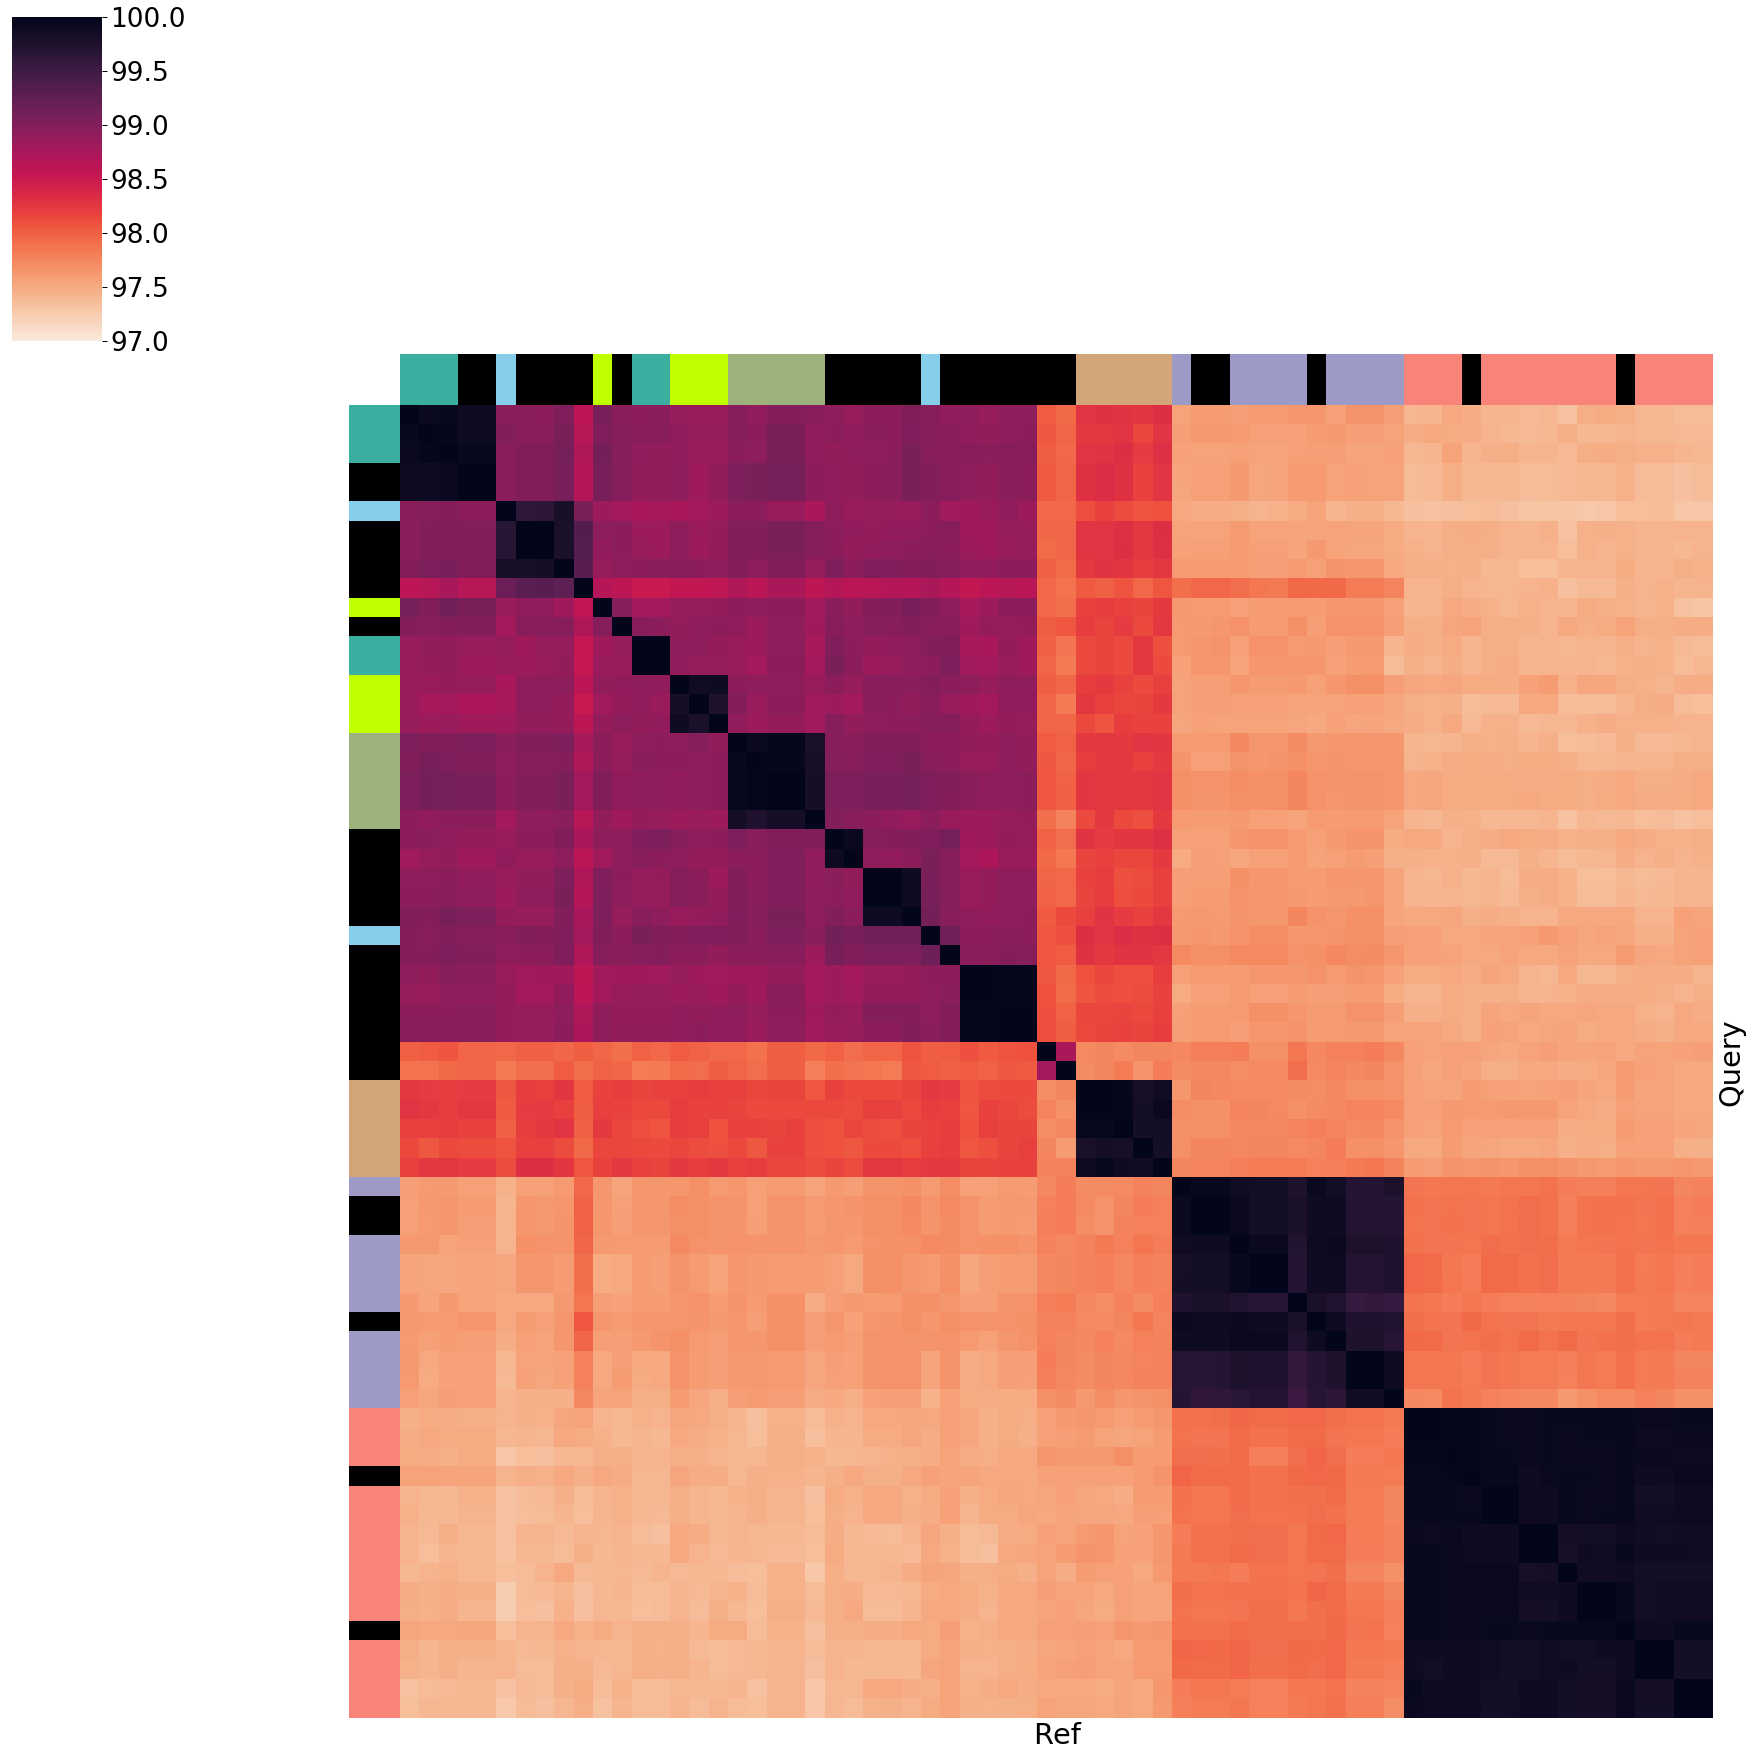

In [105]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 97 )


plt.ylabel("")
plt.xlabel("")

plt.savefig("Results5_Plots/6.Saureus68CI.ANI.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results5_Plots/6.Saureus68CI.ANI.heatmap.NoLabels.svg")

plt.show()

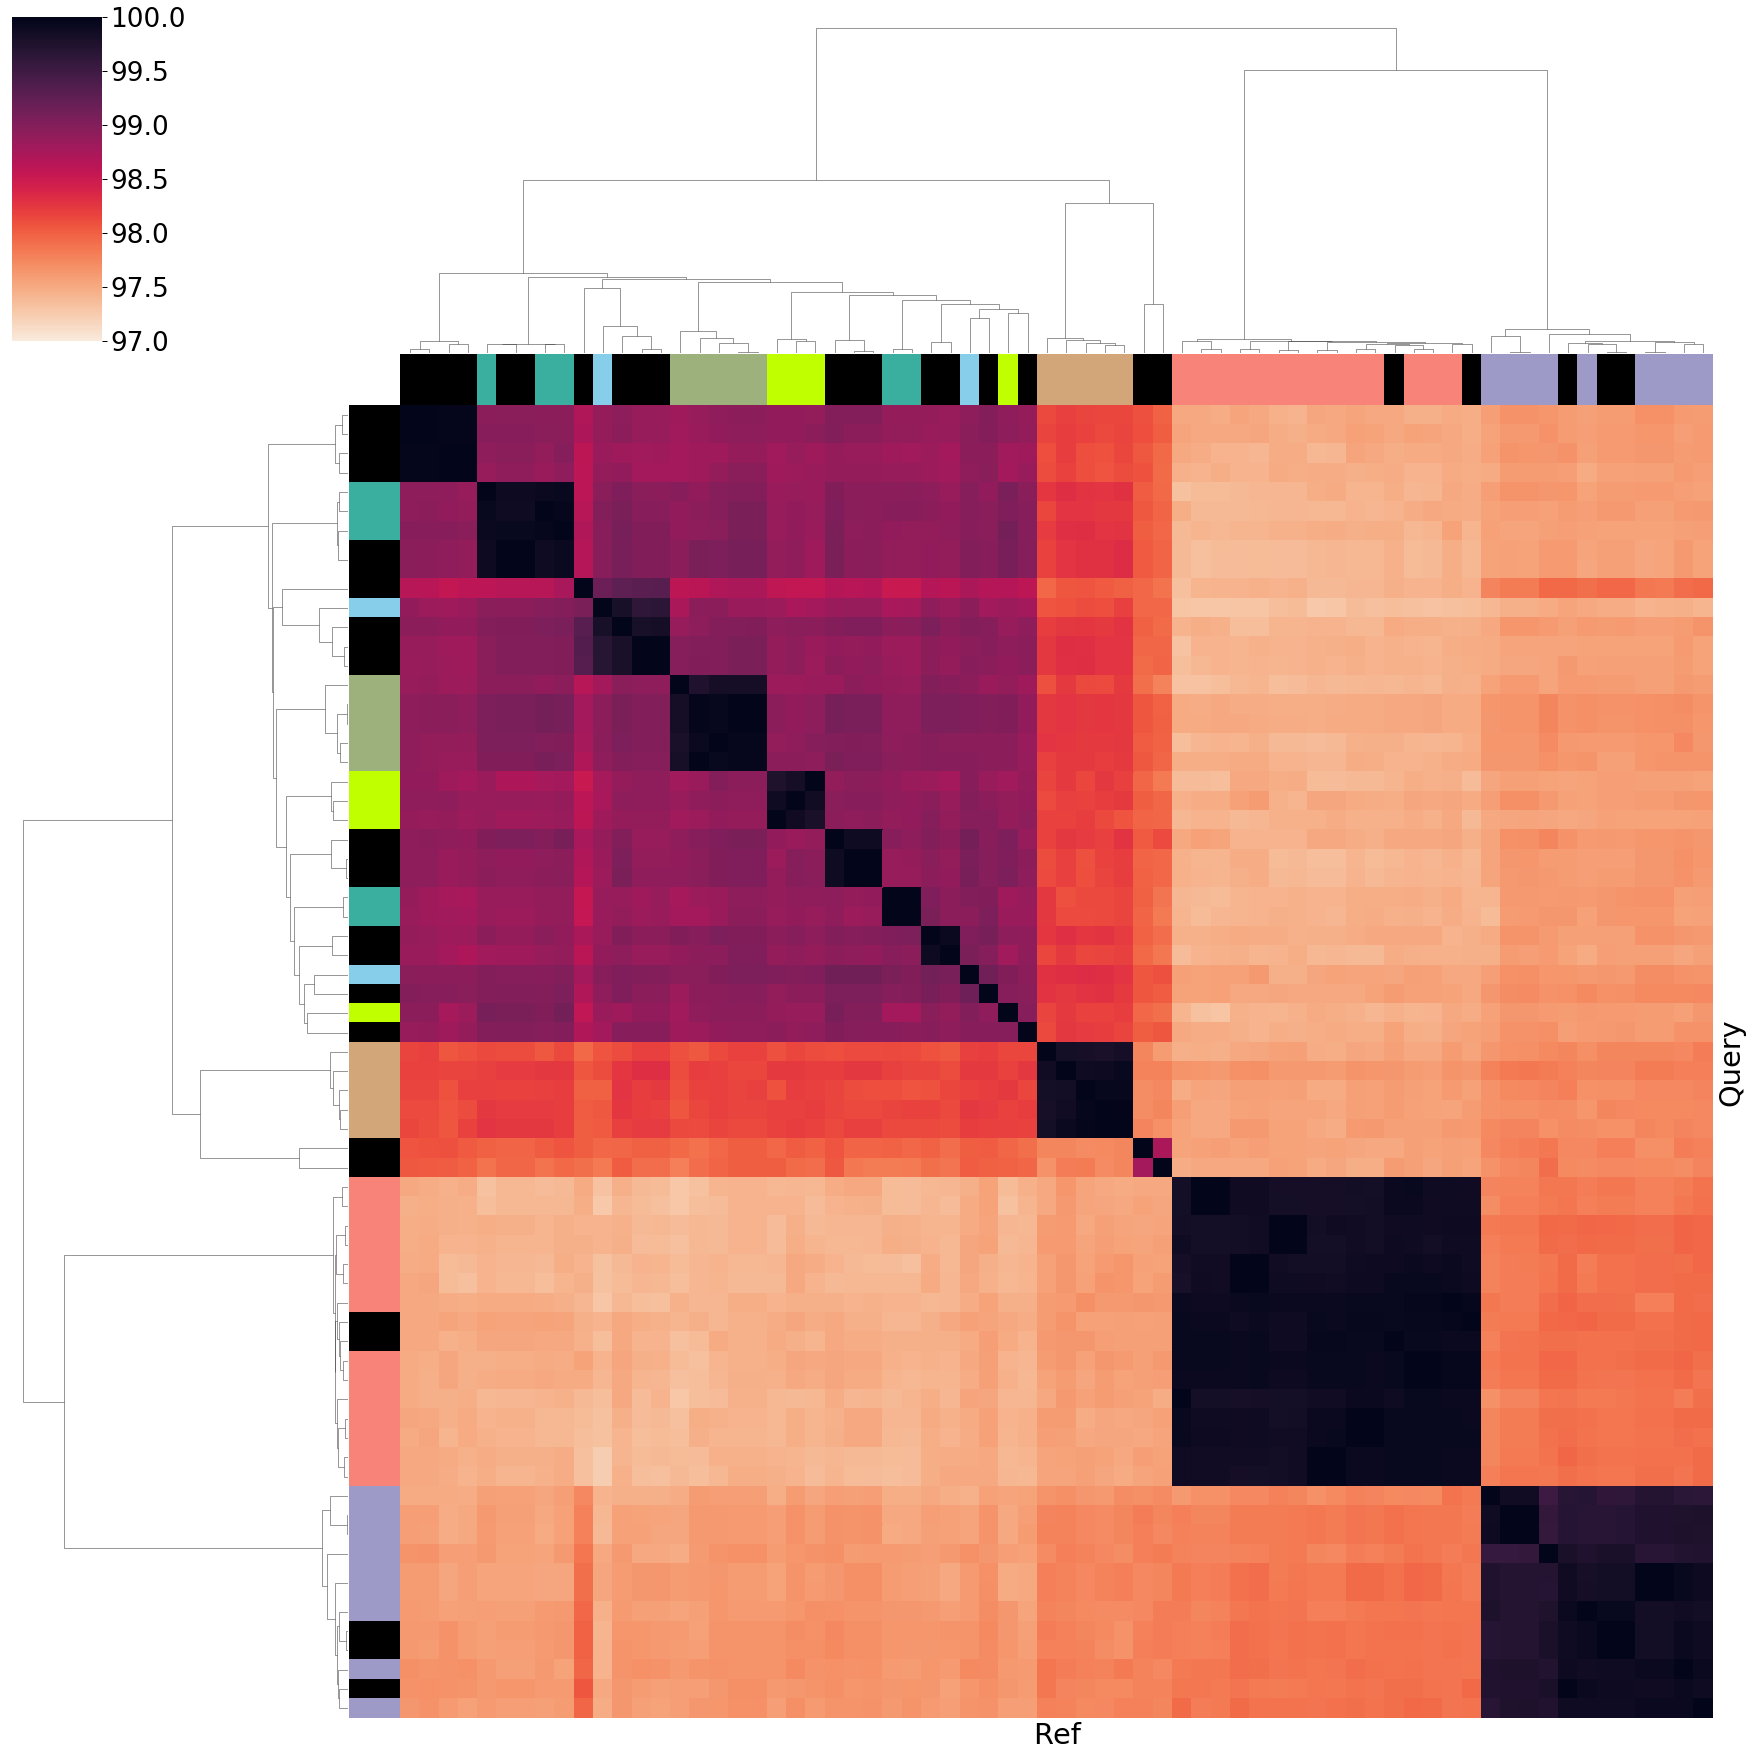

In [106]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=True, col_cluster=True,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 97 )


plt.ylabel("")
plt.xlabel("")

plt.savefig("Results5_Plots/6.Saureus68CI.ANI.ClusterMap.NoLabels.png", dpi = 300)
plt.savefig("Results5_Plots/6.Saureus68CI.ANI.ClusterMap.NoLabels.svg")

plt.show()